# Bayesian Methods for Hackers with Pyro

Porting examples from Cam Davidson-Pilon's excellent [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) to Uber's Deep Universal Probabilistic Programming language [Pyro](http://pyro.ai/) for fun and profit.

## Setup

In [0]:
#@title Default title text
# Colab package installations
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
!pip3 install torchvision
!pip3 install pyro-ppl
!pip3 install visdom
!pip3 install ipdb

In [0]:
# Imports
%matplotlib inline
import numpy as np
from scipy.stats import beta as beta_distribution, binom
import matplotlib.pyplot as plot
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import math
import torch.distributions.constraints as constraints
import random
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

## The Privacy Algorithm

*For the Bayesian Methods for Hackers formulation and PyMC3 implementation, see [here](https://colab.research.google.com/drive/1M9D9djhjYcGHOFNi8L8W-YaaBboCCvOM#scrollTo=sE5Xf36pG_v1)*

No student, even with a free-pass against punishment, would admit to cheating. What we need is a better algorithm to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preserving privacy. The following proposed algorithm is a solution I greatly admire for its ingenuity and effectiveness:

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers.

I call this the Privacy Algorithm. One could of course argue that the interviewers are still receiving false data since some Yes's are not confessions but instead randomness, but an alternative perspective is that the researchers are discarding approximately half of their original dataset since half of the responses will be noise. But they have gained a systematic data generation process that can be modeled. Furthermore, they do not have to incorporate (perhaps somewhat naively) the possibility of deceitful answers.

### Rough plan



In [0]:
def print_progress(step):
    # grab the learned variational parameters
    alpha = pyro.param("alpha").item()
    beta = pyro.param("beta").item()

    # here we use some facts about the beta distribution
    # compute the inferred mean of the coin's fairness
    inferred_mean = alpha / (alpha + beta)
    # compute inferred standard deviation
    factor = beta / (alpha * (1.0 + alpha + beta))
    inferred_std = inferred_mean * math.sqrt(factor)
    print("\n[step %i] based on the data and our prior belief\
    , the probability of a student cheating is %.3f +- %.3f" % (step, inferred_mean, inferred_std))  
    
    
def display_graph(alpha_param, beta_param):
    x = np.linspace(beta_distribution.ppf(0.001, alpha_param, beta_param, loc=0), beta_distribution.ppf(0.999, alpha_param, beta_param))
    y = beta_distribution.pdf(x, alpha_param, beta_param)

    fig, ax = plot.subplots(1, 1)
    posterior, = ax.plot(x, y, 'b-', label="cheating frequency pdf")

    ax.legend(handles=[posterior])

#Build Model:
  #frequency_cheating = uniform_distribution
  #true_answers = bernoulli(prior_frequency_cheating, N)#starting sample value?(testval)
  #first_coin_flips = bernoulli(0.5, N)#starting sample value?(testval)
  #second_coin_flips = bernoulli(0.5 N)
  #observed_trues = first_coin_flips * true_answers + ( 1- first_coin_flips) * second_coin_flipsl
  #observed_proportion = sum(observed_trues) / N
  
#Incorporate Observations:
 ## #observations = binomial(N, observed_proportion, observations)
#Run inference
#Print $$$

# result: cheating_frequency posterior

### Bernoulli Model



$$ cheating\_frequency \thicksim Beta(alpha, beta) $$
$$ true\_cheater = 0.5 * cheating\_frequency $$
$$ false\_positive = 0.5 * 0.5 $$
$$ probability\_of\_yes = true\_cheater + false\_positive $$
$$probability\_of\_yes = true\_cheater + 0.25 $$

In [0]:
N = 100
n_steps = 5000

data = torch.cat((torch.ones(35, 1), torch.zeros(65, 1)))
pyro.clear_param_store()


def model(data):
    cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Uniform(0, 1)
  )
    probability_of_true_answer = 0.5 * cheating_frequency + 0.25
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(probs=probability_of_true_answer), obs=data[i])

def guide(data):
    alpha = pyro.param('alpha', torch.tensor(10.0), constraint=constraints.positive)
    beta = pyro.param('beta', torch.tensor(10.0), constraint=constraints.positive)
    cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Beta(alpha, beta)
    )  
    
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())



#do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print_progress(step)


[step 0] based on the data and our prior belief, the probability of a student cheating is 0.500 +- 0.109

[step 100] based on the data and our prior belief, the probability of a student cheating is 0.476 +- 0.109

[step 200] based on the data and our prior belief, the probability of a student cheating is 0.456 +- 0.109

[step 300] based on the data and our prior belief, the probability of a student cheating is 0.435 +- 0.108

[step 400] based on the data and our prior belief, the probability of a student cheating is 0.415 +- 0.107

[step 500] based on the data and our prior belief, the probability of a student cheating is 0.399 +- 0.106

[step 600] based on the data and our prior belief, the probability of a student cheating is 0.382 +- 0.105

[step 700] based on the data and our prior belief, the probability of a student cheating is 0.366 +- 0.104

[step 800] based on the data and our prior belief, the probability of a student cheating is 0.352 +- 0.102

[step 900] based on the data 

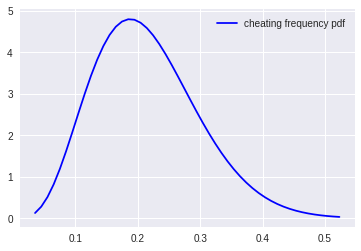

In [0]:
def display_graph(alpha_param, beta_param):
    x = np.linspace(beta_distribution.ppf(0.001, alpha_param, beta_param, loc=0), 
                    beta_distribution.ppf(0.999, alpha_param, beta_param))
    y = beta_distribution.pdf(x, alpha_param, beta_param)

    fig, ax = plot.subplots(1, 1)
    posterior, = ax.plot(x, y, 'b-', label="cheating frequency pdf")

    ax.legend(handles=[posterior])
    
display_graph(pyro.param("alpha").item(), pyro.param("beta").item())

### Binomial Model

In [0]:
N = 100
n_steps = 5000

data = torch.cat((torch.ones(35, 1), torch.zeros(65, 1)))

pyro.clear_param_store()
def model(data):
  cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Uniform(0, 1)
  )
  probability_of_true_answer = 0.5 * cheating_frequency + 0.25
  pyro.sample("obs", dist.Binomial(N, probs=probability_of_true_answer), obs=data.sum())
  

def guide(data):
  alpha = pyro.param('alpha', torch.tensor(10.0), constraint=constraints.positive)
  beta = pyro.param('beta', torch.tensor(10.0), constraint=constraints.positive)
  cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Beta(alpha, beta)
  )
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
  svi.step(data)
  if step % 100 == 0:
    print_progress(step)


[step 0] based on the data and our prior belief, the probability of a student cheating is 0.500 +- 0.109

[step 100] based on the data and our prior belief, the probability of a student cheating is 0.478 +- 0.109

[step 200] based on the data and our prior belief, the probability of a student cheating is 0.456 +- 0.109

[step 300] based on the data and our prior belief, the probability of a student cheating is 0.435 +- 0.108

[step 400] based on the data and our prior belief, the probability of a student cheating is 0.416 +- 0.107

[step 500] based on the data and our prior belief, the probability of a student cheating is 0.399 +- 0.106

[step 600] based on the data and our prior belief, the probability of a student cheating is 0.381 +- 0.105

[step 700] based on the data and our prior belief, the probability of a student cheating is 0.366 +- 0.104

[step 800] based on the data and our prior belief, the probability of a student cheating is 0.352 +- 0.102

[step 900] based on the data 

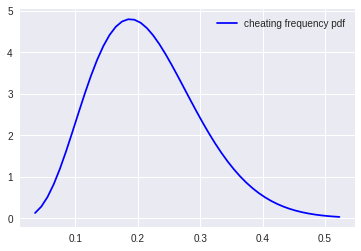

In [0]:
display_graph(pyro.param("alpha").item(), pyro.param("beta").item())

### Binomial Model with sampled coin flips


In [0]:
N = 100

n_steps = 5000
data = torch.cat((torch.ones(35, 1), torch.zeros(65, 1)))

pyro.clear_param_store()
def model(data):
  cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Uniform(0, 1)
  )
  
  true_answers = []
  first_flips  = []
  second_flips = []  
  for i in pyro.irange("coin_flipping", len(data)):
    true_answer = pyro.sample("true_answer_{}".format(i), dist.Bernoulli(probs=cheating_frequency) )
    true_answers.append(true_answer)
    first_flip = pyro.sample("first_coin_flips_{}".format(i), dist.Bernoulli(probs=0.5) )
    first_flips.append(first_flip)
    second_flip = pyro.sample("second_coin_flips_{}".format(i), dist.Bernoulli(probs=0.5))
    second_flips.append(second_flip)
    
  
  true_answers = torch.tensor(true_answers)
  first_coin_flips = torch.tensor(first_flips)
  second_coin_flips = torch.tensor(second_flips)

  observed_trues = first_coin_flips * true_answers + ( 1- first_coin_flips) * second_coin_flips
  
  observed_proportion = observed_trues.sum() / N
  pyro.sample("obs", dist.Binomial(probs=observed_proportion, total_count=len(data)), obs=data.sum())

  
def guide(data):
  alpha = pyro.param('alpha', torch.tensor(10.0), constraint=constraints.positive)
  beta = pyro.param('beta', torch.tensor(10.0), constraint=constraints.positive)
  cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Beta(alpha, beta)
  )
  for i in pyro.irange("coin_flipping", len(data)):
    pyro.sample("true_answer_{}".format(i), dist.Bernoulli(probs=cheating_frequency) )
    pyro.sample("first_coin_flips_{}".format(i), dist.Bernoulli(probs=0.5) )
    pyro.sample("second_coin_flips_{}".format(i), dist.Bernoulli(probs=0.5))
  
# setup the optimizer
adam_params = {"lr": 0.0015, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
  svi.step(data)
  if step % 100 == 0:
    print_progress(step)

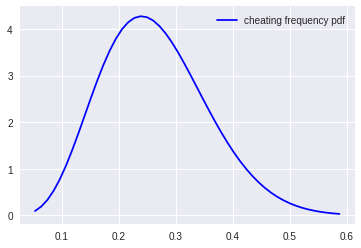

In [0]:
display_graph(pyro.param("alpha").item(), pyro.param("beta").item())

# Binomial Model using 'expand'

In [1]:
n_steps = 10000
data = torch.cat((torch.ones(35, 1), torch.zeros(65, 1)))

pyro.clear_param_store()
def model(data):
    cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Uniform(0, 1)
    )

    true_answers = pyro.sample("true_answers", 
                                dist.Bernoulli(probs=cheating_frequency).expand(len(data)).independent(1))
    first_coin_flips = pyro.sample("first_coin_flips", 
                                dist.Bernoulli(probs=0.5).expand(len(data)).independent(1))
    second_coin_flips = pyro.sample("second_coin_flips", 
                                    dist.Bernoulli(probs=0.5).expand(len(data)).independent(1))

    observed_trues = first_coin_flips * true_answers + (1 - first_coin_flips) * second_coin_flips

    observed_proportion = observed_trues.sum() / len(data)
    pyro.sample("obs", dist.Binomial(probs=observed_proportion, total_count=len(data)), obs=data.sum())

def guide(data):
    alpha = pyro.param('alpha', torch.tensor(10.0), constraint=constraints.positive)
    beta = pyro.param('beta', torch.tensor(10.0), constraint=constraints.positive)
    cheating_frequency = pyro.sample(
     'cheating_frequency',
      dist.Beta(alpha, beta)
  )
    pyro.sample("true_answers", 
                dist.Bernoulli(probs=cheating_frequency).expand(len(data)).independent(1))
    pyro.sample("first_coin_flips", 
                dist.Bernoulli(probs=0.5).expand(len(data)).independent(1))
    pyro.sample("second_coin_flips", 
                dist.Bernoulli(probs=0.5).expand(len(data)).independent(1))

# setup the optimizer
adam_params = {"lr": 0.003, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print_progress(step)

NameError: name 'torch' is not defined

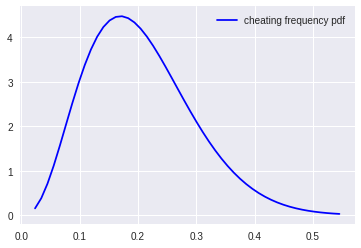

In [0]:
display_graph(pyro.param("alpha").item(), pyro.param("beta").item())